# Sparkify Project 
This workspace contains a medium size daset run on IBM watson studio (242.6 MB) of the full dataset available (12GB). The dataset used for this analysis has been provided by Udacity

In [107]:
# import libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window

from pyspark.sql.functions import *
from pyspark.sql.types import *

import numpy as np
import pandas as pd
import datetime
from time import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import (NaiveBayes, LogisticRegression, DecisionTreeClassifier, 
                                       RandomForestClassifier, LinearSVC, GBTClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline

In [2]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-49f62c15-1c72-402b-93a1-1865afb794bb',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 's-X0yZ-fT0d82Ligo8nkqxahtrUdn4I-ML8ecxumkGIB'
}

configuration_name = 'os_701baecdee924b88aebde6a9a590e9fe_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-kmgfhyjqkfjpv6'))
df_data_1.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

#### let's see the schema 

In [4]:
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
#count of events 
df_data_1.count()

543705

In [6]:
len(df_data_1.columns)

18

In [7]:
df_data_1.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|543705|          528005|543705| 543705|          

## 1. Identify missing data and clean the dataset 
dataset : medium-sparkify-event-data.json, Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
plt.style.use('fivethirtyeight')

Text(0.5, 1.0, 'nulls in each column')

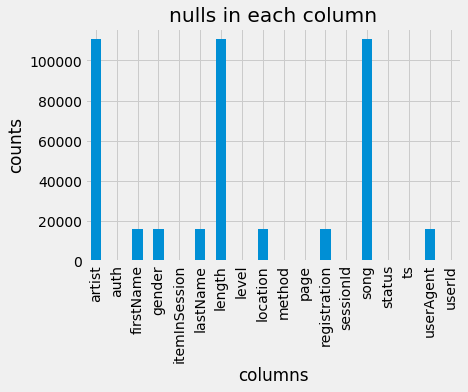

In [9]:
col_null={}
for i in df_data_1.columns :
    col_null[i]=df_data_1.where(col(i).isNull()).count()
col_null=pd.Series(col_null)
ax=col_null.plot(kind='bar')
ax.set_xlabel('columns')
ax.set_ylabel('counts')
ax.set_title('nulls in each column')
    

There are columns with good null values, the null count looks similar for columns for example (artist, length, song). There is a pattern in NULL counts. Important attribute such as userID is not null also sessionID

In [10]:
#lets look at userid as well as sessionid 
df_data_1.createOrReplaceTempView('sparkify')
spark.sql(
    '''
    SELECT DISTINCT userId
    FROM sparkify
    ORDER BY userId
    '''
).show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [11]:
#remove empty string from the result-set above
df_data_1=df_data_1.filter("userId != ''")

In [12]:
df_data_1.collect()
df_data_1.count()

528005

In [13]:
# check for sessionID 
df_data_1.filter(col('sessionid').isNull()).collect()

[]

In [14]:
#lets check for duplicate values in the datset and drop duplicate useID as well as sessionID
df_data_1.select('userId').dropDuplicates().sort('userId').show(4)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 4 rows



In [15]:
#remove duplictate sessionIds
df_data_1.select('sessionId').dropDuplicates().count()

4470

Text(0.5, 1.0, 'nulls in each column')

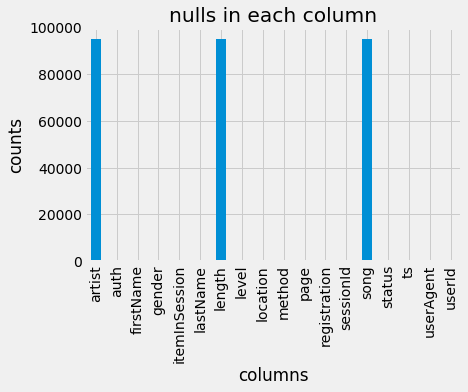

In [17]:
col_null={}
for i in df_data_1.columns :
    col_null[i]=df_data_1.where(col(i).isNull()).count()
col_null=pd.Series(col_null)
ax=col_null.plot(kind='bar')
ax.set_xlabel('columns')
ax.set_ylabel('counts')
ax.set_title('nulls in each column')

artist, song and length can be null as they are not all pages in app, other values that we saw as null are removed now

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
#lets create a view on the cleaned data 
df_data_1.createOrReplaceTempView('sparkify_cleaned')
spark.sql(
    '''
    SELECT count(*) 
    FROM sparkify_cleaned
   
    '''
).show()

+--------+
|count(1)|
+--------+
|  528005|
+--------+



In [19]:
# let's take a look at the artists 
spark.sql(
    '''
    SELECT DISTINCT artist
    FROM sparkify_cleaned
    ORDER BY artist
    '''
).show()

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|        '68 Comeback|
|'N Sync/Phil Collins|
|        'Til Tuesday|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|                 -M-|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
+--------------------+
only showing top 20 rows



In [20]:
#top 5 artists 
group_by_artist = spark.sql(
    '''
    SELECT artist, count(*) as count
    FROM sparkify_cleaned
    WHERE artist IS NOT null
    GROUP BY artist
    ORDER BY count(*) desc
    LIMIT 5
    '''
).toPandas()

Text(0.5, 1.0, 'Top 5 artists in Sparkify')

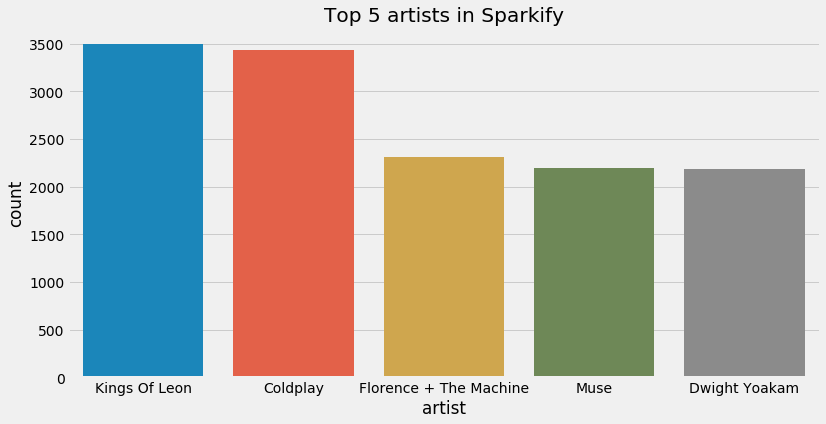

In [21]:
plt.figure(figsize=(12,6))
sns.barplot(x='artist', y='count', data=group_by_artist,dodge=False, )
plt.title('Top 5 artists in Sparkify')

In [22]:
#lets look at the second column - authentication 
auth =spark.sql(
    '''
    SELECT DISTINCT auth, count(*) as count
    FROM sparkify_cleaned
    GROUP BY auth
    ORDER BY auth
    '''
).toPandas()

Text(0.5, 1.0, 'auth  Sparkify')

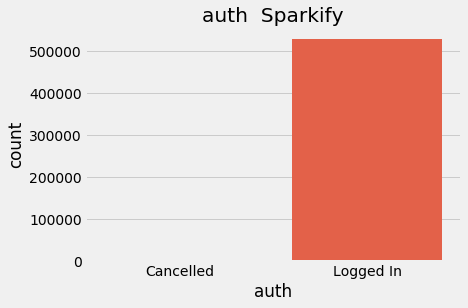

In [23]:
plt.figure(figsize=(6,4))
sns.barplot(x='auth', y='count', data=auth )
plt.title('auth  Sparkify')

In [24]:
auth

,auth,count
0,Cancelled,99
1,Logged In,527906


In [25]:
#lets go to the next column - gender 
# Gender
gender = spark.sql(
    '''
    SELECT gender, count(*) as count
    FROM sparkify_cleaned
    GROUP BY gender
    ORDER BY count(*) desc
    '''
).toPandas()

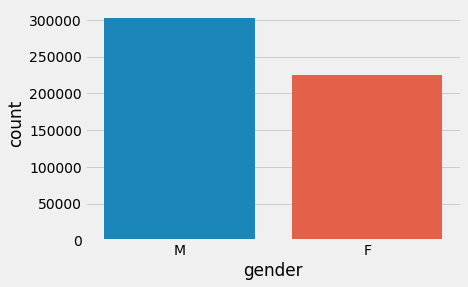

In [26]:
plt.figure(figsize=(6,4))
sns.barplot(x='gender', y='count', data=gender)
plt.show()

That's a lot of counts lets check distinct counts


In [27]:
distinct_count_gender = spark.sql(
    '''
    SELECT gender, count(DISTINCT userId) as count
    FROM sparkify_cleaned
    GROUP BY gender
    ORDER BY count(*) desc
    '''
).toPandas()


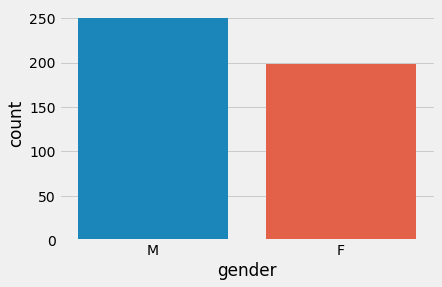

In [28]:
#distinct user distribution by Gender 
plt.figure(figsize=(6,4))
sns.barplot(x='gender', y='count', data=distinct_count_gender)
plt.show()

In [29]:
distinct_count_gender

,gender,count
0,M,250
1,F,198


In [30]:
#lets go to the next logical column in the dataset and identify levels by unique userId
# look at distinct users
level = spark.sql(
    '''
    SELECT level, count(DISTINCT userId) as count
    FROM sparkify_cleaned
    GROUP BY level
    ORDER BY count(*) desc
    '''
).toPandas()

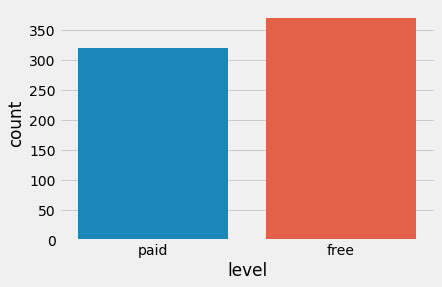

In [31]:
plt.figure(figsize=(6,4))
sns.barplot(x='level', y='count', data= level)
plt.show()

In [32]:
level

,level,count
0,paid,321
1,free,370


In [33]:
#Identify the top locations 
ocation = spark.sql(
    '''
    SELECT location, count(*) as count
    FROM sparkify_cleaned
    GROUP BY location
    ORDER BY count(*) desc
    LIMIT 5
    '''
).toPandas()



(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

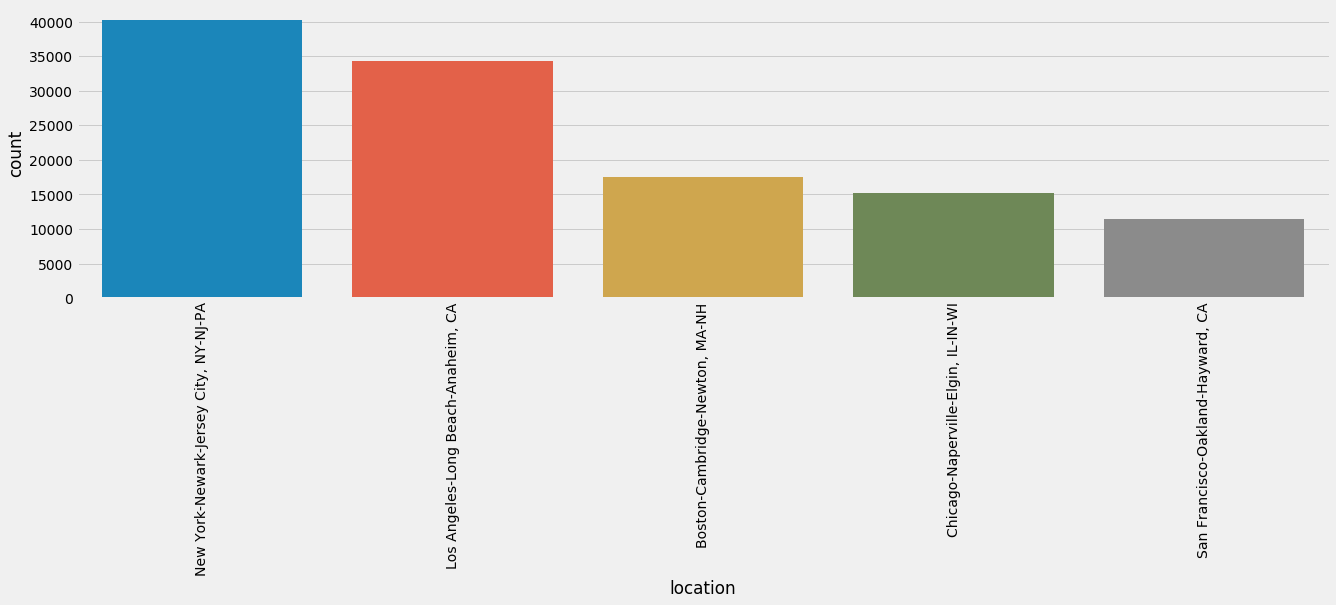

In [34]:
plt.figure(figsize=(20,5))
sns.barplot(x='location', y='count', data= ocation)
plt.xticks(rotation=90)


In [35]:
#lets look at the next logical attribute page

spark.sql(
    '''
    SELECT page, count(*) as count
    FROM sparkify_cleaned
    GROUP BY page
    ORDER BY count(*) desc
    '''
).toPandas()

,page,count
0,NextSong,432877
1,Thumbs Up,23826
2,Home,19089
3,Add to Playlist,12349
4,Add Friend,8087
5,Roll Advert,7773
6,Logout,5990
7,Thumbs Down,4911
8,Downgrade,3811
9,Settings,2964


In [36]:
#check churn count in the data with Cancellation Confirmation page for both paid and free users
churn_count=df_data_1.select(['userId','page']).filter("page=='Cancellation Confirmation'").dropDuplicates().count()
churn_count

99

This is equal to row 18 of our previous resultset that can be used for identifying churn but before that lets look at the data that will help us with feature engineering 

In [37]:
songs = spark.sql(
    '''
    SELECT song, count(*) as count
    FROM sparkify_cleaned
    WHERE song IS NOT null
    GROUP BY song
    ORDER BY count(*) DESC
    LIMIT 10
    '''
).toPandas()



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

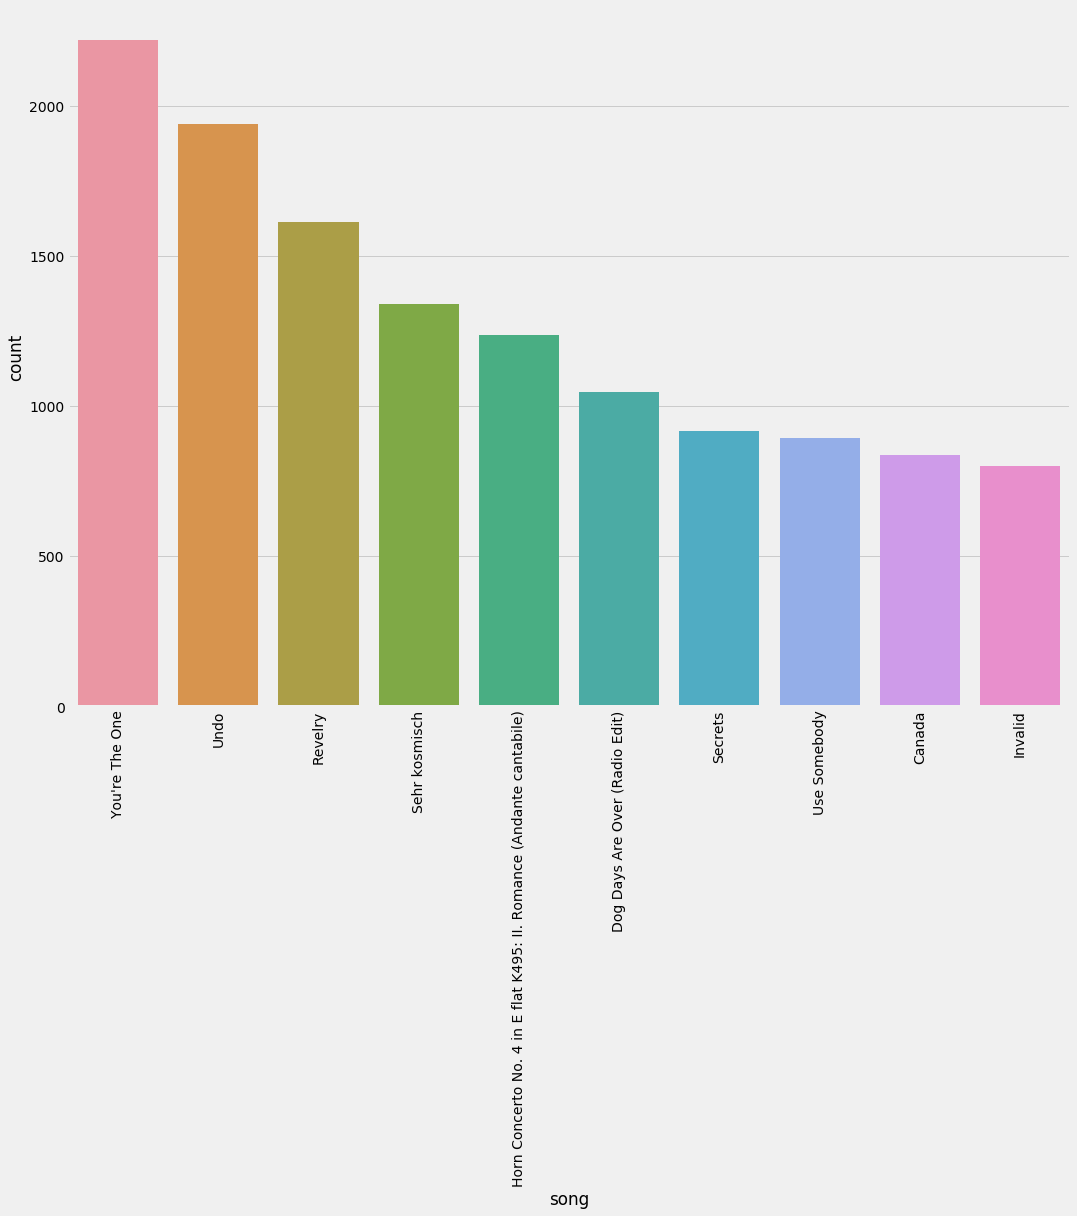

In [38]:
plt.figure(figsize=(16,12))
sns.barplot(x='song', y='count', data=songs)
plt.xticks(rotation=90)

In [39]:
#lets add the churned column by finding the users who cancelled 
users_churned=df_data_1.filter(df_data_1.page == 'Cancellation Confirmation').select('userId').dropDuplicates().toPandas()
get_churn=udf(lambda x : 1 if x in users_churned.userId.values else 0)
df_data_1=df_data_1.withColumn('Churn',get_churn(df_data_1.userId))
df_data_1.collect()
df_data_1.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, Churn: string]

In [40]:
df_data_1.createOrReplaceTempView('sparkify_cleaned_churn')
spark.sql(
    '''
    SELECT count(*) 
    FROM sparkify_cleaned_churn
   
    '''
).show()

+--------+
|count(1)|
+--------+
|  528005|
+--------+



In [41]:
churn_by_gender = spark.sql(
    '''
    SELECT   count(DISTINCT userId) as count,gender, Churn
    FROM sparkify_cleaned_churn
    group by gender, Churn 
   
    '''
).show()

+-----+------+-----+
|count|gender|Churn|
+-----+------+-----+
|   54|     M|    1|
|   45|     F|    1|
|  153|     F|    0|
|  196|     M|    0|
+-----+------+-----+



In [42]:
churn_by_gender = spark.sql(
    '''
    SELECT   count(DISTINCT userId) as count,gender, Churn
    FROM sparkify_cleaned_churn
    group by gender, Churn 
   
    '''
).toPandas()

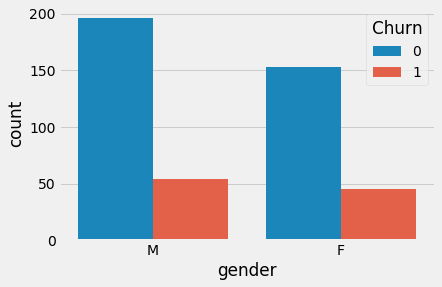

In [43]:
sns.barplot(x='gender',y='count' ,hue='Churn', data=churn_by_gender)


slightly more males have churned than females. There are more males in the dataset than females, could be one possible reason that could explain the numbers 

In [44]:
#lets check churn by level 
churn_by_level =spark.sql(
    '''
    SELECT    level, count(Churn)
    FROM sparkify_cleaned_churn
    WHERE page=='Cancellation Confirmation'
    group by level
   
    '''
).toPandas()

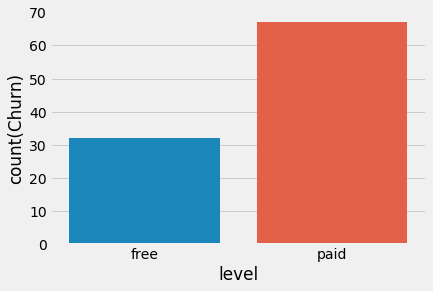

In [45]:
sns.barplot(x='level',y='count(Churn)' , data=churn_by_level)

More paid users are churning then non-paid users

In [46]:
#lets move to time analysis by defining user defined functions from the field ts 

extract_time=udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
extract_hour=udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%H"))
extract_day=udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%a"))

In [47]:
#apply this on the dataframe and then append it back 

df_data_1=df_data_1.withColumn('time',extract_time(df_data_1.ts))
df_data_1=df_data_1.withColumn('hour',extract_hour(df_data_1.ts))
df_data_1=df_data_1.withColumn('day',extract_day(df_data_1.ts))

In [48]:
df_data_1.select(['userId','time','hour','day','level','sessionId']).sort('ts').show(5)

+------+-------------------+----+---+-----+---------+
|userId|               time|hour|day|level|sessionId|
+------+-------------------+----+---+-----+---------+
|   293|2018-10-01 00:00:11|  00|Mon| free|      292|
|    98|2018-10-01 00:00:25|  00|Mon| free|       97|
|   179|2018-10-01 00:01:58|  00|Mon| paid|      178|
|   179|2018-10-01 00:01:59|  00|Mon| paid|      178|
|   246|2018-10-01 00:02:04|  00|Mon| paid|      245|
+------+-------------------+----+---+-----+---------+
only showing top 5 rows



In [49]:
df_data_1.createOrReplaceTempView('sparkify_cleaned_churn_time')
spark.sql(
    '''
    SELECT count(*) 
    FROM sparkify_cleaned_churn_time
   
    '''
).show()

+--------+
|count(1)|
+--------+
|  528005|
+--------+



In [50]:
group_day = spark.sql(
    '''
    SELECT day, count(Churn) AS count, Churn
    FROM sparkify_cleaned_churn_time
    WHERE page=='NextSong'
    GROUP BY day, Churn 
    ORDER by day
    '''
).toPandas()


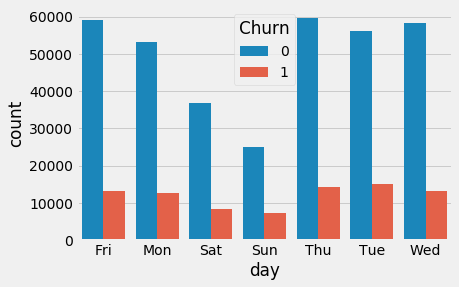

In [51]:
sns.barplot(x='day',y='count' ,hue ='Churn' , data=group_day)

In [52]:
#lets go deeper from days to hours 
group_hour = spark.sql(
    '''
    SELECT hour, count(Churn) AS count, Churn
    FROM sparkify_cleaned_churn_time
    WHERE page=='NextSong'
    GROUP BY hour, Churn 
    ORDER by hour
    '''
).toPandas()

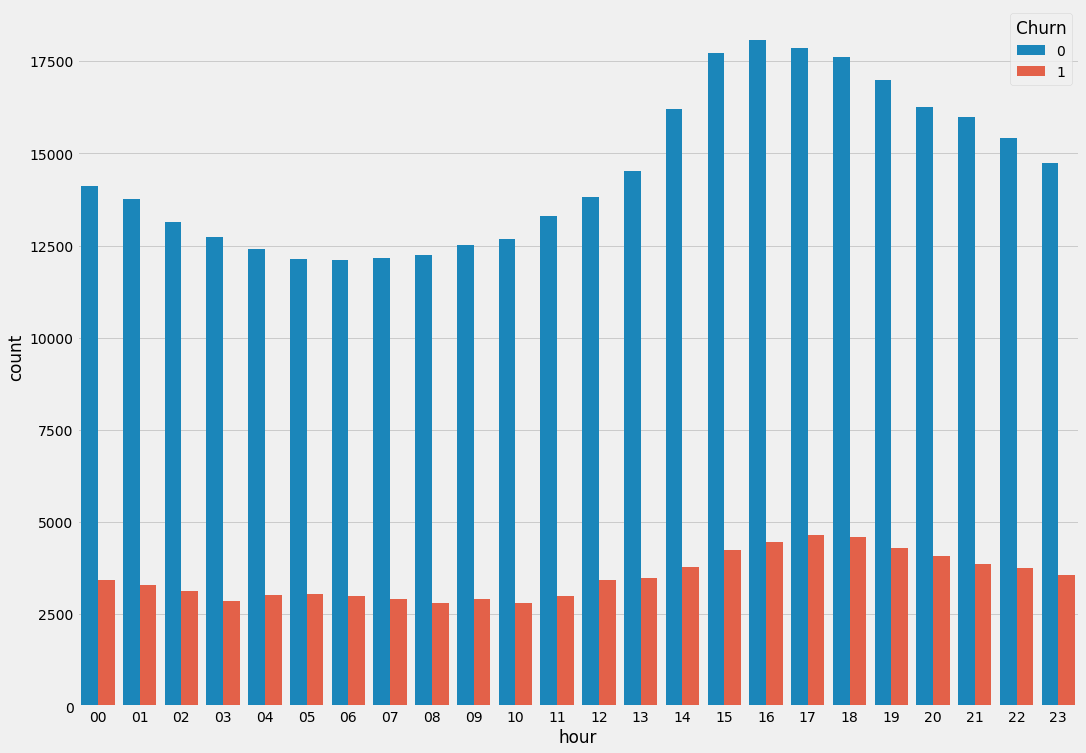

In [53]:
plt.figure(figsize=(16,12))
sns.barplot(x='hour',y='count' ,hue ='Churn' , data=group_hour)

both churners and non-churners tend to listen to more songs after 14:00

In [54]:
#avg count of songs by sesssion 
song_count_by_session = spark.sql(
    '''
    SELECT  count(Churn) AS count, Churn
    FROM sparkify_cleaned_churn_time
    WHERE page=='NextSong'
    GROUP BY userId, sessionId ,Churn 
    
    '''
).toPandas()

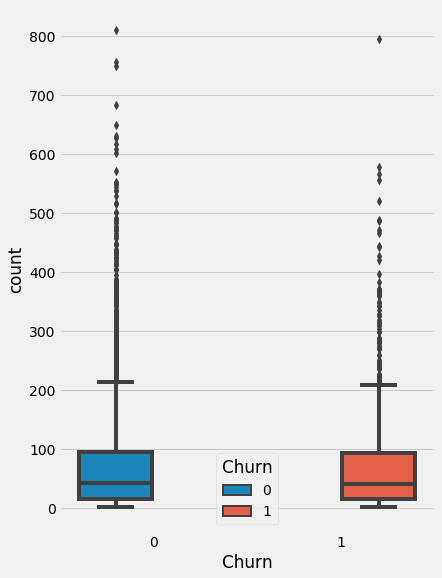

In [55]:
plt.figure(figsize=(6,9))
sns.boxplot(x='Churn',y='count' ,hue ='Churn', data=song_count_by_session)

In [56]:
#lets split it by. gender and see 

song_count_by_session_gender = spark.sql(
    '''
    SELECT  count(Churn) AS count, Churn,gender
    FROM sparkify_cleaned_churn_time
    WHERE page=='NextSong'
    GROUP BY userId, sessionId ,Churn, gender
    
    '''
).toPandas()


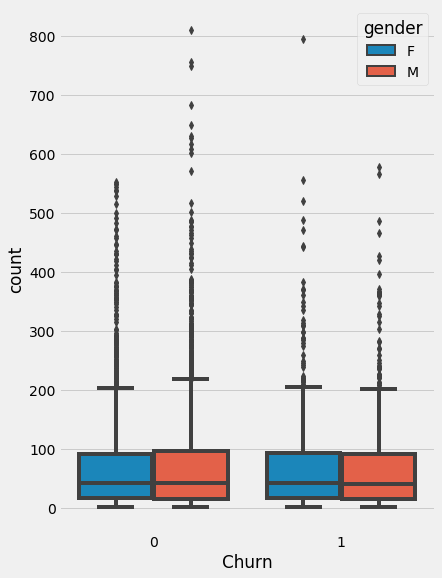

In [57]:
plt.figure(figsize=(6,9))
sns.boxplot(x='Churn',y='count' ,hue ='gender', data=song_count_by_session_gender)

There is a slight less activity on the female non-churners than on churners but not any visibile diffrence in other groups let us dwelve to state level and see if there is a diffrence. Lets also check if there is a corelation between pages and churn

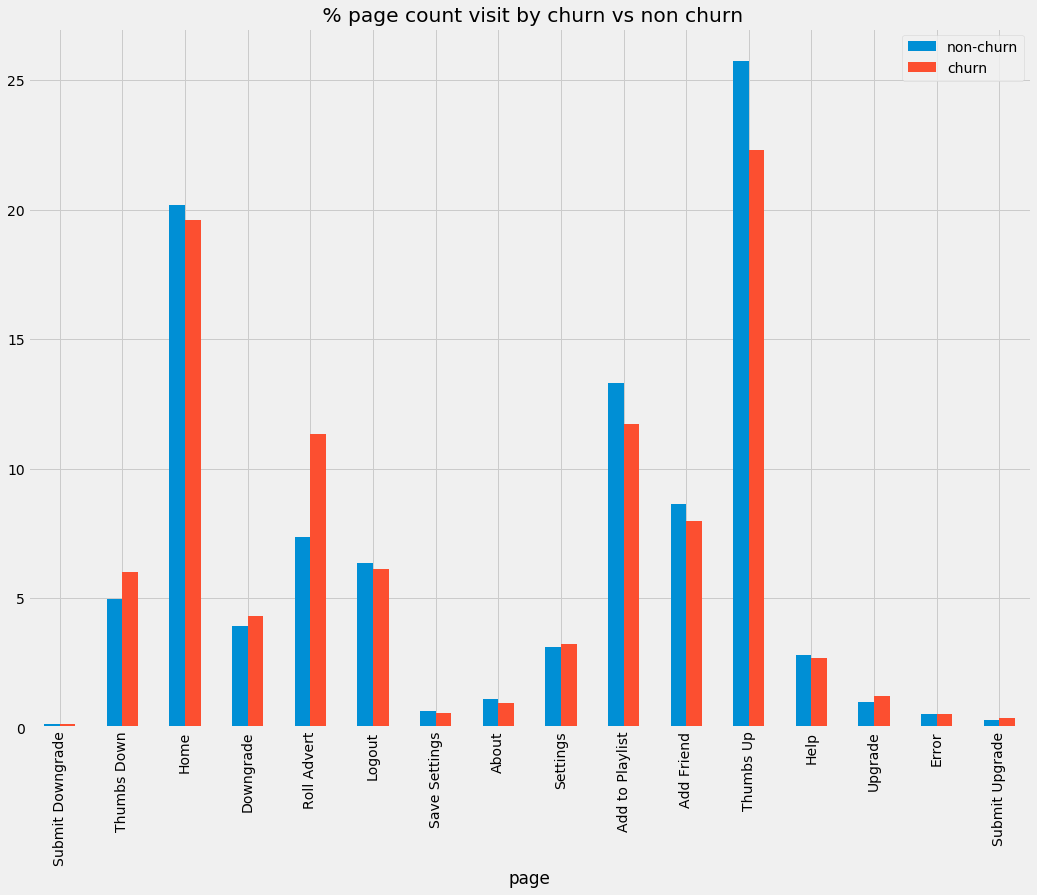

In [58]:
page_count_churn=df_data_1.filter("Churn = 1 and page != 'NextSong'").groupby('page').count().withColumnRenamed('count','churn').toPandas()
page_churn_sum=page_count_churn['churn'].sum()

page_count_no_churn=df_data_1.filter("Churn= 0 and page != 'NextSong'").groupby('page').count().withColumnRenamed('count','non-churn').toPandas()
page_no_churn_sum=page_count_no_churn['non-churn'].sum()

#normailze to percentage 
page_count_churn['churn']=page_count_churn['churn']/page_churn_sum*100
page_count_no_churn['non-churn']=page_count_no_churn['non-churn']/page_no_churn_sum*100


page_count=page_count_no_churn.merge(page_count_churn,on='page',how='left')
page_count.set_index(page_count.page,inplace=True)
page_count.plot(kind='bar',figsize=(16,12), title= " % page count visit by churn vs non churn");

churners tend to dislike music (Thumbs down) more than non-churners. Further advertising (roller advert) tends to put off the churners

In [59]:
#lets check churn by state 
#define a function to get last 2 letters of state
get_state=udf(lambda x : x.split(',')[-1].strip())

In [60]:

df_data_1=df_data_1.withColumn('State',get_state(df_data_1.location))
df_data_1.collect()
df_data_1.persist();

In [61]:
df_data_1.createOrReplaceTempView('sparkify_cleaned_churn_state')
spark.sql(
    '''
    SELECT count(*) 
    FROM sparkify_cleaned_churn_state
   
    '''
).show()

+--------+
|count(1)|
+--------+
|  528005|
+--------+



In [62]:
state_count_by_session = spark.sql(
    '''
    SELECT  count(distinct userId) as count, Churn, State
    FROM sparkify_cleaned_churn_state
    GROUP BY  Churn, State  
    
    '''
).toPandas()

Text(0.5, 1.0, 'churn count by state')

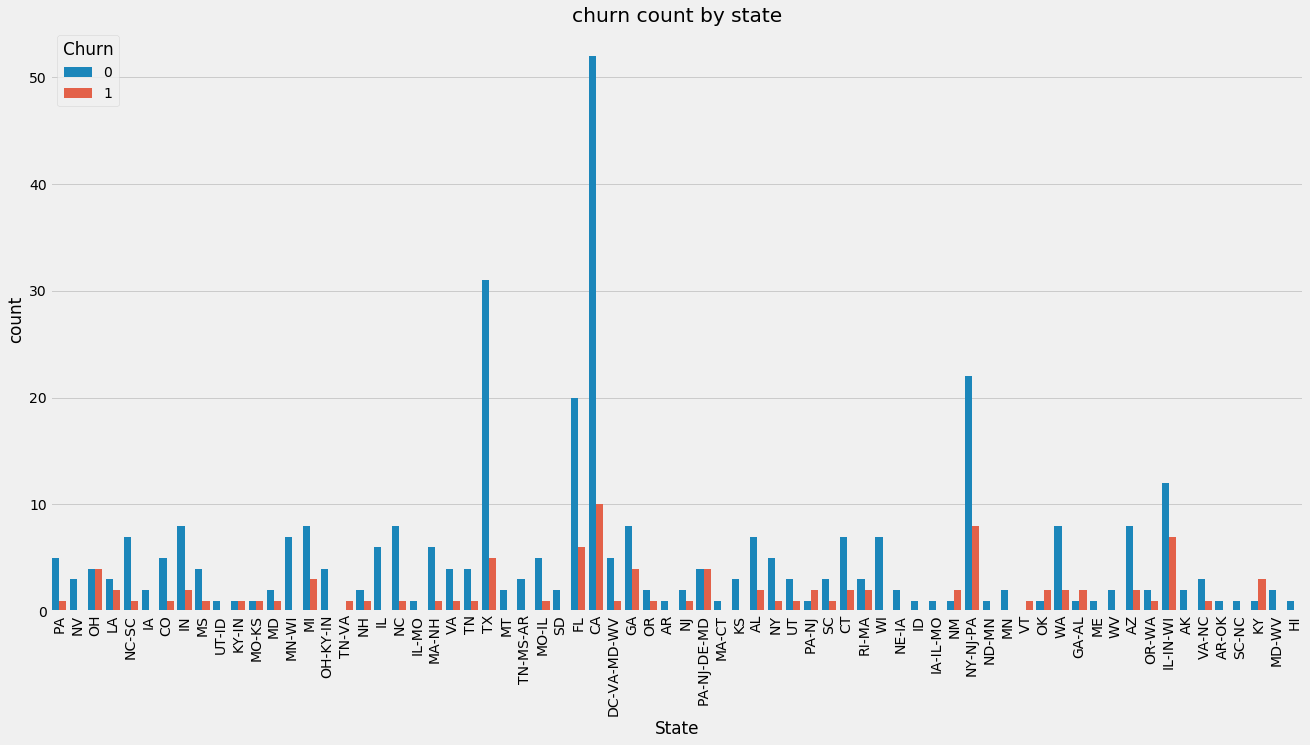

In [63]:
plt.subplots(figsize=(20,10))
sns.barplot(x='State',y='count',hue='Churn',data= state_count_by_session)
plt.xticks(rotation=90)
plt.title('churn count by state')

some sates have similar churn as california which has the largest userbase, Sparkify should focus efforts on retention in 'NY-NJ-PA, OH has equal churners as well as non churners

In [64]:
tot_life_time=df_data_1.select(['userId','registration','ts']).groupby(['userId','registration']).max('ts').withColumnRenamed('max(ts)','ts')
tot_life_time=tot_life_time.withColumn('tot_life_time',((tot_life_time.ts-tot_life_time.registration)/1000/3600/24)).select(['userId','tot_life_time'])

In [65]:
tot_life_time.collect()
tot_life_time.persist()

DataFrame[userId: string, tot_life_time: double]

In [66]:
tot_life_time = tot_life_time.join(df_data_1.select('userId','Churn').dropDuplicates(),'userId','outer').toPandas()

Text(0.5, 1.0, 'liftime of user from registration')

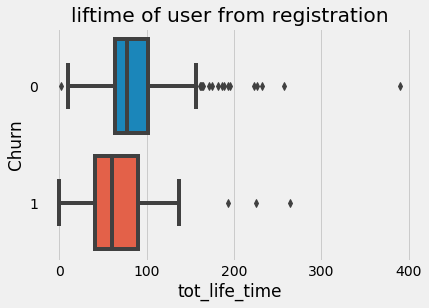

In [67]:
sns.boxplot(x='tot_life_time', y='Churn', orient="h", data=tot_life_time)
plt.title('liftime of user from registration')


churner's total life-time is less than non churners 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [68]:
#lets check the schema after all prior transforms 
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- State: string (nullable = true)



The Good features based on EDA:
* A. Thumbs up and down 
* B. Gender 
* C. Churn Label
* D. Total number of sessions per user 
* E. Time of user on Sparkify since regsitration 
* F. Total songs listend by the User on their playlist 
* G. Number of Friends added 
* H. Number of artist the user has listened to 
* I. upgrade / downgrade based on page 
* J. Level of the user 

In [69]:
#A. Thumbs up and down 


f1 = df_data_1\
    .select('userID','page') \
    .where(df_data_1.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'thumb_up') 
f1.describe().show()

f2 = df_data_1 \
    .select('userID','page') \
    .where(df_data_1.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'thumb_down')
f2.describe().show()

+-------+------------------+-----------------+
|summary|            userID|         thumb_up|
+-------+------------------+-----------------+
|  count|               439|              439|
|   mean| 67308.81548974942|54.27334851936219|
| stddev|106228.80408254794|69.94135178778983|
|    min|                10|                1|
|    max|                99|              506|
+-------+------------------+-----------------+

+-------+------------------+------------------+
|summary|            userID|        thumb_down|
+-------+------------------+------------------+
|  count|               389|               389|
|   mean| 70031.19537275065|12.624678663239074|
| stddev|106895.73735311363|13.582432851937988|
|    min|                10|                 1|
|    max|                99|                80|
+-------+------------------+------------------+



In [70]:
#B.Gender also code gender as '1' or '0' format needed for ML algorithim 

f3 = df_data_1 \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
f3.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571| 0.4419642857142857|
| stddev|105964.58428485188|0.49717562790790387|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [71]:
#C.Churn Label changing it to label, to indicate predictor 

label = df_data_1 \
    .select('userId', col('Churn').alias('label')) \
    .dropDuplicates()
label.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              label|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571|0.22098214285714285|
| stddev|105964.58428485185| 0.4153723104396363|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [72]:
#D. Total number of sessions per user 
f4=df_data_1\
.select(['userId','sessionId'])\
.dropDuplicates()\
.groupby('userId')\
.count()\
.withColumnRenamed('count','tot_num_session')
f4.describe().show()

+-------+-----------------+------------------+
|summary|           userId|   tot_num_session|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|13.571428571428571|
| stddev|105964.5842848519|13.171023911802266|
|    min|               10|                 1|
|    max|               99|                92|
+-------+-----------------+------------------+



In [73]:
#E. Time of user on Sparkify since regsitration 
f5 = df_data_1 \
    .select('userId','registration','ts') \
    .withColumn('total_life',(df_data_1.ts-df_data_1.registration)) \
    .groupBy('userId') \
    .agg({'total_life':'max'}) \
    .withColumnRenamed('max(total_life)','total_life') \
    .select('userId', (col('total_life')/1000/3600/24).alias('total_life'))
f5.describe().show()


+-------+-----------------+-------------------+
|summary|           userId|         total_life|
+-------+-----------------+-------------------+
|  count|              448|                448|
|   mean|67520.34821428571|   82.8322214988426|
| stddev|105964.5842848519|  40.54572803476974|
|    min|               10|-0.5227314814814815|
|    max|               99|  390.3197569444444|
+-------+-----------------+-------------------+



In [74]:
#F. Total songs listned  to by each user 
f6 = df_data_1 \
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
f6.describe().show()

+-------+------------------+------------------+
|summary|            userID|       total_songs|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|1178.5825892857142|
| stddev|105964.58428485187| 1380.627964752404|
|    min|                10|                 3|
|    max|                99|              9767|
+-------+------------------+------------------+



In [75]:
#G. Number of Friends added
f7 = df_data_1 \
    .select('userID','page') \
    .where(df_data_1.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_friend') 
f7.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               409|               409|
|   mean|  66368.3716381418|19.772616136919314|
| stddev|106064.01609030599| 22.49443576627283|
|    min|                10|                 1|
|    max|                99|               158|
+-------+------------------+------------------+



In [76]:
#H. Number of artist the user has listened to
f8 = df_data_1 \
    .filter(df_data_1.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "artist_count")
f8.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|658.9799107142857|
| stddev|105964.58428485185| 625.882698051957|
|    min|                10|                1|
|    max|                99|             3507|
+-------+------------------+-----------------+



In [77]:
#upgrade / downgrade based on page

upgrade_downgrade = df_data_1\
                  .filter("page== 'Submit Downgrade' or page== 'Submit Upgrade'") \
                  .select(['userId','page','ts'])\
                 .groupby(['userId','page'])\
                 .max('ts')
upgrade_downgrade.collect();

In [78]:
user_downgrade=upgrade_downgrade.filter("page=='Submit Downgrade'").select('userId').toPandas()
user_upgrade=upgrade_downgrade.filter("page=='Submit Upgrade'").select('userId').toPandas()
get_downgrade=udf(lambda x: 1 if x in user_downgrade.userId.values else 0)
get_upgrade=udf(lambda x: 1 if x in user_upgrade.userId.values else 0)

In [79]:
#feature for downgrade
f9 =df_data_1\
    .select('userId')\
    .dropDuplicates()
f9=f9.withColumn('downgrade',get_downgrade(f9.userId))
f9.describe().show()

+-------+------------------+-------------------+
|summary|            userId|          downgrade|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571|0.21651785714285715|
| stddev|105964.58428485187|0.41233163564838404|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [80]:
#feature for upgrade 
f10 =df_data_1\
    .select('userId')\
    .dropDuplicates()
f10=f10.withColumn('upgrade',get_upgrade(f10.userId))
f10.describe().show()


+-------+------------------+------------------+
|summary|            userId|           upgrade|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|0.5200892857142857|
| stddev|105964.58428485184|  0.50015477789743|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [81]:
#Level of the user 
f11=df_data_1\
    .select(['userId','ts'])\
    .groupby('userId').max('ts')\
    .withColumnRenamed('max(ts)','ts')\
    .dropDuplicates()
f11=f11.join(df_data_1.select(['userId','ts','level']).dropDuplicates(),['userId','ts'],'left_outer')
get_level = udf(lambda x : 1 if x == 'paid' else 0)
f11=f11.withColumn('level_int',get_level(f11.level)).select("userId",col('level_int').alias('level'))
f11.describe().show()

+-------+-----------------+------------------+
|summary|           userId|             level|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|0.6160714285714286|
| stddev|105964.5842848518|0.4868845526338666|
|    min|               10|                 0|
|    max|               99|                 1|
+-------+-----------------+------------------+



In [82]:
# Construct the dataset for ML
data_feat = f1.join(f2,'userID','outer') \
    .join(f3,'userID','outer') \
    .join(f4,'userID','outer') \
    .join(f5,'userID','outer') \
    .join(f6,'userID','outer') \
    .join(f7,'userID','outer') \
    .join(f8,'userID','outer') \
    .join(f9,'userID','outer') \
    .join(f10,'userID','outer') \
    .join(f11,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data_feat.show(5)

+--------+----------+------+---------------+------------------+-----------+----------+------------+---------+-------+-----+-----+
|thumb_up|thumb_down|gender|tot_num_session|        total_life|total_songs|add_friend|artist_count|downgrade|upgrade|level|label|
+--------+----------+------+---------------+------------------+-----------+----------+------------+---------+-------+-----+-----+
|       4|         3|     1|              2|14.328449074074074|        137|         3|          94|        0|      0|    0|    1|
|      15|         5|     0|              5| 53.32314814814814|        395|         2|         287|        0|      1|    1|    1|
|       8|         0|     1|              5| 26.63826388888889|        152|         2|         108|        0|      1|    1|    1|
|       3|         1|     0|              3|105.42211805555554|         84|         3|          61|        0|      0|    0|    0|
|     102|        15|     1|             17| 112.5537962962963|       2156|        26|    

In [83]:
data_feat.printSchema()

root
 |-- thumb_up: long (nullable = true)
 |-- thumb_down: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- tot_num_session: long (nullable = true)
 |-- total_life: double (nullable = false)
 |-- total_songs: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- artist_count: long (nullable = true)
 |-- downgrade: string (nullable = true)
 |-- upgrade: string (nullable = true)
 |-- level: string (nullable = true)
 |-- label: string (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In pyspark the machine learning Algorithims needs data in vectorized format. Hence, use VectorAssembler to assemble all features into a vector also all the features need to numeric

In [84]:
cols = ["thumb_up", "thumb_down", "gender",'tot_num_session','total_life','total_songs','add_friend','artist_count','downgrade', 'upgrade', 'level']

In [85]:
# we have upgrade,downgarde, level, label as string, let's convert all to double 
for col in cols :
    data_feat=data_feat.withColumn(col,data_feat[col].cast(DoubleType()))
    data_feat=data_feat.withColumn('label',data_feat.label.cast(DoubleType()))
    data_feat.collect()
    data_feat.persist()
    data_feat.take(1)

In [86]:
data_feat.printSchema()

root
 |-- thumb_up: double (nullable = true)
 |-- thumb_down: double (nullable = true)
 |-- gender: double (nullable = true)
 |-- tot_num_session: double (nullable = true)
 |-- total_life: double (nullable = false)
 |-- total_songs: double (nullable = true)
 |-- add_friend: double (nullable = true)
 |-- artist_count: double (nullable = true)
 |-- downgrade: double (nullable = true)
 |-- upgrade: double (nullable = true)
 |-- level: double (nullable = true)
 |-- label: double (nullable = true)



In [87]:
#vectorize
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data_feat = assembler.transform(data_feat)

In [88]:
data_feat.take(1)

[Row(thumb_up=4.0, thumb_down=3.0, gender=1.0, tot_num_session=2.0, total_life=14.328449074074074, total_songs=137.0, add_friend=3.0, artist_count=94.0, downgrade=0.0, upgrade=0.0, level=0.0, label=1.0, NumFeatures=DenseVector([4.0, 3.0, 1.0, 2.0, 14.3284, 137.0, 3.0, 94.0, 0.0, 0.0, 0.0]))]

Standardize the features by taking off the mean and divided by the standard deviation of each feature

In [89]:
from pyspark.ml.feature import StandardScaler

In [91]:
scl = StandardScaler(inputCol="NumFeatures", outputCol="features",
                        withStd=True, withMean=False)

scale = scl.fit(data_feat)
data_feat = scale.transform(data_feat)
data_feat.collect()
data_feat.take(1)

[Row(thumb_up=4.0, thumb_down=3.0, gender=1.0, tot_num_session=2.0, total_life=14.328449074074074, total_songs=137.0, add_friend=3.0, artist_count=94.0, downgrade=0.0, upgrade=0.0, level=0.0, label=1.0, NumFeatures=DenseVector([4.0, 3.0, 1.0, 2.0, 14.3284, 137.0, 3.0, 94.0, 0.0, 0.0, 0.0]), features=DenseVector([0.0574, 0.2246, 2.0114, 0.1518, 0.3534, 0.0992, 0.1351, 0.1502, 0.0, 0.0, 0.0]))]

In [92]:
# split train, test and validation
train, test = data_feat.randomSplit([0.7, 0.3])
valid, test = test.randomSplit([0.5, 0.5])

### 1. Logistic Regression 

In [93]:
# split train, test and validation
train, test = data_feat.randomSplit([0.7, 0.3])
valid, test = test.randomSplit([0.5, 0.5])

In [94]:
# Logistic Regression
#f1
#5 fold CV
lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_grid = ParamGridBuilder().build()
cv = CrossValidator(estimator=lr,
                    evaluator=evaluator,
                    estimatorParamMaps=param_grid,
                    numFolds=5)

evaluator will be the same for all the ML Models 

In [95]:
#train 
cv_lr_fit=cv.fit(train)

In [96]:
#fit model on test dataset
lr_pred=cv_lr_fit.transform(test)

In [97]:
#check prediction scores on test 
print('Accuracy: ', evaluator.evaluate(
    lr_pred, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(lr_pred, {evaluator.metricName: 'f1'}))

Accuracy:  0.859375
F1 Score:  0.8188374125874125


In [98]:
# using best model of cv to validate
lr_best = cv_lr_fit.bestModel
lr_best.extractParamMap()

{Param(parent='LogisticRegression_3818c28aa55f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_3818c28aa55f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_3818c28aa55f', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_3818c28aa55f', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_3818c28aa55f', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_3818c28aa55f', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_3818c28aa55f', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [99]:
# use the best above model to test on validation set 
lr_valid = cv_lr_fit.transform(valid)
print('Accuracy: ', evaluator.evaluate(
    lr_valid, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(lr_valid, {evaluator.metricName: 'f1'}))

Accuracy:  0.7631578947368421
F1 Score:  0.6727272727272727


### 2. Support Vector Machine

In [101]:
#SVM

svc = LinearSVC()
param_grid_svc = ParamGridBuilder().build()
cv_svc = CrossValidator(estimator=svc,
                        evaluator=evaluator,
                        estimatorParamMaps=param_grid_svc,
                        numFolds=5)

In [ ]:
#fit the model on the training set 
svc_fit=cv_svc.fit(train)

In [103]:
svc_pred = svc_fit.transform(test)

In [104]:
#check performance on test 
print('Accuracy: ', evaluator.evaluate(
    svc_pred, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(svc_pred, {evaluator.metricName: 'f1'}))

Accuracy:  0.859375
F1 Score:  0.7943802521008404


In [105]:
# using best model based on cv to validate
svc_valid = svc_fit.transform(valid)
print('Accuracy: ', evaluator.evaluate(
    svc_valid, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(
    svc_valid, {evaluator.metricName: 'f1'}))

Accuracy:  0.75
F1 Score:  0.6428571428571428


### 3. Gradient Boosting Tree

In [108]:
# Gradient Boosting
gb = GBTClassifier(seed=0)
param_grid_gb = ParamGridBuilder().build()
cv_gb = CrossValidator(estimator=gb,
                       evaluator=evaluator,
                       estimatorParamMaps=param_grid_gb,
                       numFolds=5)

In [ ]:
# fit train and predict test
gb_fit=cv_gb.fit(train)


In [110]:
gb_pred = gb_fit.transform(test)

In [111]:
# Performance on test 
print('Accuracy: ', evaluator.evaluate(gb_pred, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(gb_pred, {evaluator.metricName: 'f1'}))

Accuracy:  0.828125
F1 Score:  0.8318596088845968


In [113]:
# using best model to validate
gb_valid = gb_fit.transform(valid)
print('Accuracy: ', evaluator.evaluate(gb_valid, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(gb_valid, {evaluator.metricName: 'f1'}))

Accuracy:  0.7631578947368421
F1 Score:  0.7197802197802197


In [116]:
#best model on GB
gb_best = gb_fit.bestModel
imp_feat=gb_best.featureImportances.values

In [117]:
y = np.arange(len(cols))

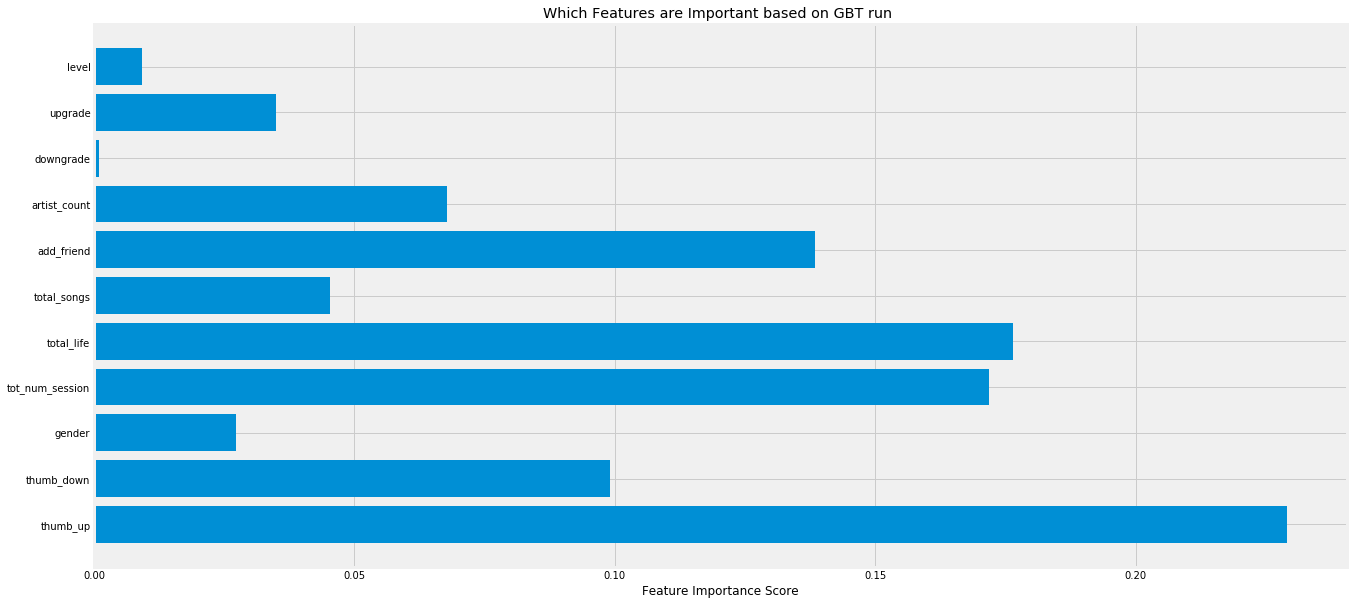

In [120]:
plt.subplots(figsize=(20,10))
plt.barh(y, imp_feat, align='center')
plt.yticks(y, cols)
plt.xlabel('Feature Importance Score')
plt.title('Which Features are Important based on GBT run ');

##### thumb_up is an important feature, indicating people get the music they like,  they are more likely to stick to the platform (less churn) 

In [121]:
#Random Forest 
rf = RandomForestClassifier()
param_grid_rf = ParamGridBuilder().build()
cv_rf = CrossValidator(estimator=rf,
                       evaluator=evaluator,
                       estimatorParamMaps=param_grid_rf,
                       numFolds=5)

In [122]:
rf_fit=cv_rf.fit(train)

In [124]:
rf_pred = rf_fit.transform(test)

In [125]:
#check performance on test 
print('Accuracy: ', evaluator.evaluate(rf_pred, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(rf_pred, {evaluator.metricName: 'f1'}))

Accuracy:  0.859375
F1 Score:  0.8558724165341812


In [127]:
# using best model to validate
rf_valid = rf_fit.transform(valid)
print('Accuracy: ', evaluator.evaluate(rf_valid, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(rf_valid, {evaluator.metricName: 'f1'}))

Accuracy:  0.7894736842105263
F1 Score:  0.7395833333333334


### Evaluation metrics on on the 4 Machine Learning models 

Based on **validation set**  Accuracy and F1 Score (rounded to 3 decimals), I have ordered the Models from the best performing one to the worst 

1. The **random forest** model has an Accuracy of: **0.789**, and F1 score of: **0.740**
2. The **gradient boosted trees** model has an Accuracy of: **0.763**, and F1 score of: **0.720**
3. The **logistic regression** model has an Accuracy of: **0.763**, and F1 score of: **0.673**
4. The **support vector machine** model has a accuracy of: **0.750**, and F1 score of: **0.643**

# Conclusion 

#### Cleaning the data :
- Cleaned the dataset: removed no userId datapoints, 
- Removed duplicate sessionId
- Transformed timestamp, extracted hours, days 
- Changed gender to binary numeric column.
- Changed Level to binary 

#### Feature Engineering :

- 11 features were built for the model based on **EDA**.
- Features were standardized to avoid imbalanced weighting on any one feature

#### Modeling :

- Evaluated 4 models: logistic regression, Gradient Boosted Trees, Support Vector Machines, and Random Forest 
- Utilized cross validation and grid search for fine tuning. 
- Best Accuracy **79%**  and **0.74** F1 score on validation set

#### Learning :
- Feature Engineering is very impoartant to build a good performing model. EDA is quite an important step that aids to identify features.

#### Further Model Improvement :
- Increasing the data size has the potential to improve the model.  